In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
%matplotlib inline

In [3]:
sns.set(style="darkgrid")

## Read the data

In [4]:
hands = pd.read_csv("hands7.csv")

In [5]:
games = pd.read_csv("games7.csv")

### Test plots

## Basic hands analysis

### State statistics

A histogram with x labels indicate which state is which.

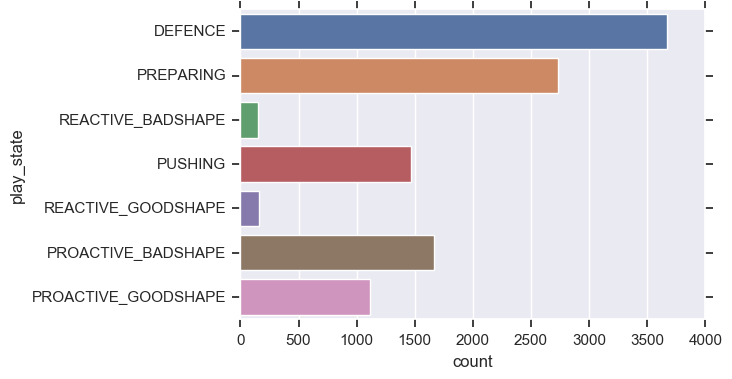

In [6]:
sns.countplot(y=hands["play_state"])

### State boxplot
I need to clearly see the average EV of each state.

Note that the "REACTIVE" data is too less. Not enough to adjust the algorithm.

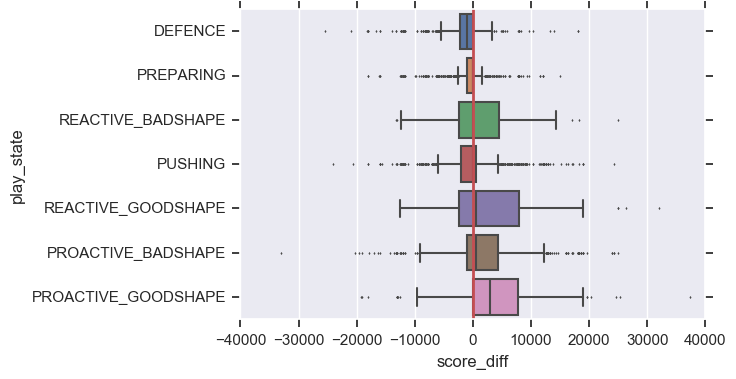

In [7]:
sns.boxplot(x="score_diff", y="play_state", data=hands, fliersize=1)
plt.axvline(color='r', linewidth=2)

### Score and meld times

(-10000, 10000)

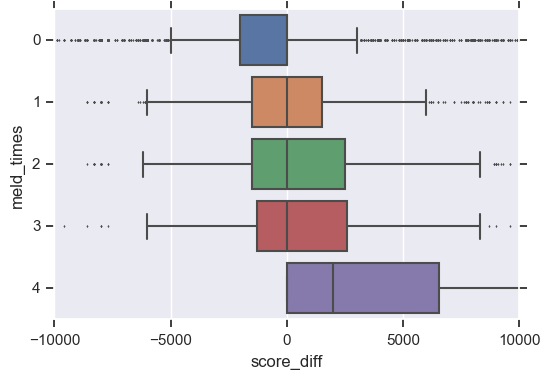

In [8]:
ax = sns.boxplot(x="score_diff", y="meld_times", orient="h", data=hands, fliersize=1)
ax.set_xlim(-10000, 10000)

### Defence when have melds

(-10000, 10000)

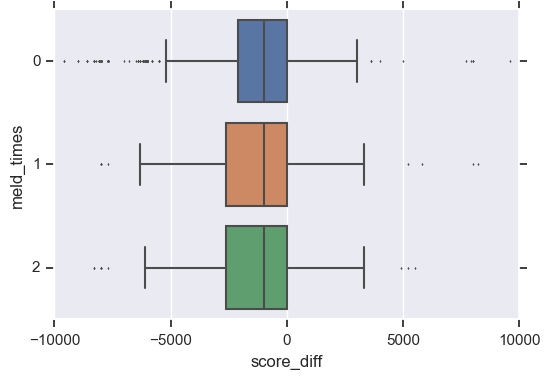

In [9]:
## defence when melded
ax = sns.boxplot(x="score_diff", y="meld_times", orient="h", data=hands[(hands["play_state"] == "DEFENCE") & (hands["meld_times"] < 3)], fliersize=1)
ax.set_xlim(-10000, 10000)

### Offense when have melds

(-10000, 10000)

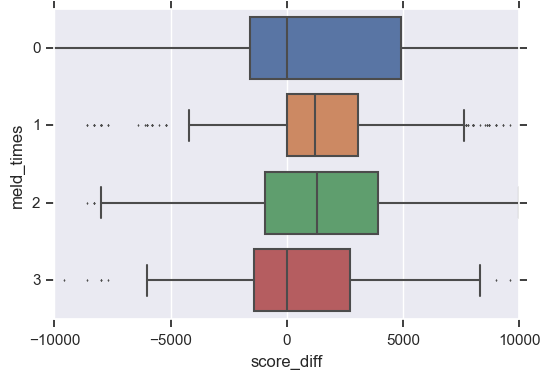

In [10]:
## offense when melded
ax = sns.boxplot(x="score_diff", y="meld_times", orient="h", data=hands[(hands["play_state"] != "DEFENCE") & (hands["play_state"] != "PREPARING") & (hands["meld_times"] < 4)], fliersize=1)
ax.set_xlim(-10000, 10000)

### Score and reach

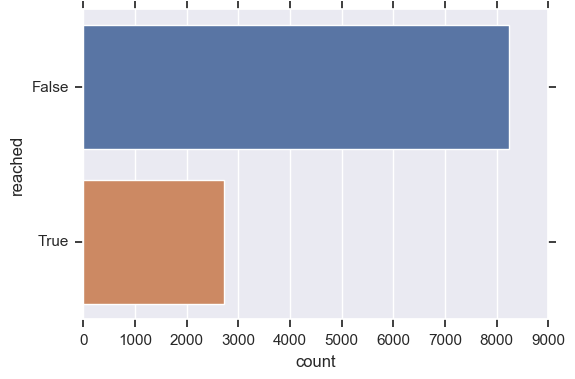

In [11]:
sns.countplot(y="reached", data=hands)

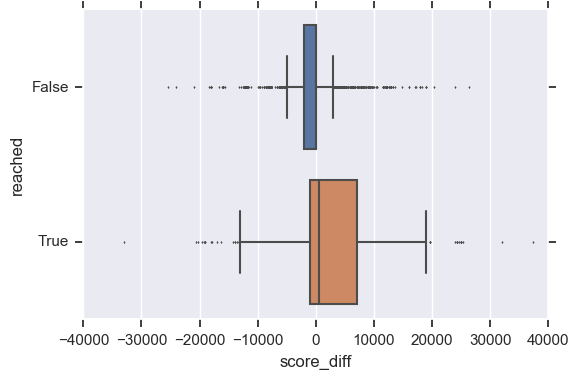

In [12]:
sns.boxplot(x="score_diff", y="reached", orient="h", data=hands, fliersize=1)

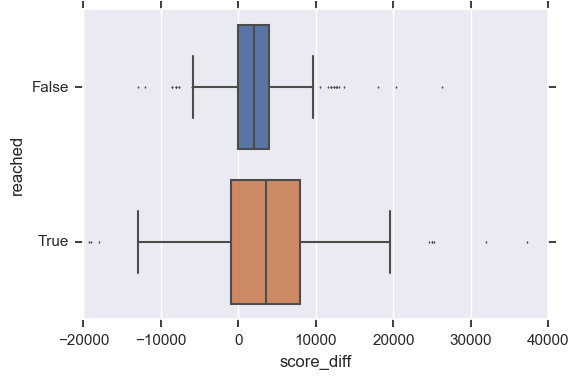

In [13]:
## GoodShape
sns.boxplot(x="score_diff", y="reached", orient="h", data=hands[(hands["play_state"]=="PROACTIVE_GOODSHAPE") | (hands["play_state"]=="REACTIVE_GOODSHAPE")], fliersize=1)

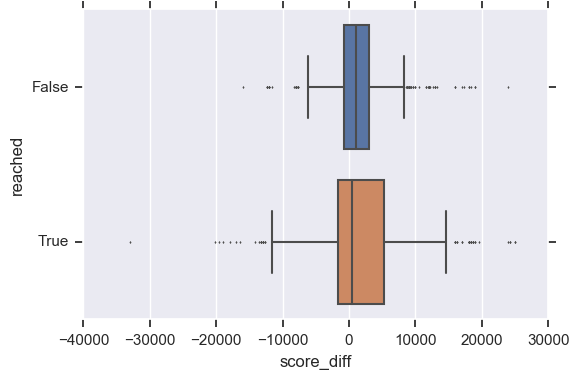

In [14]:
## BadShape
sns.boxplot(x="score_diff", y="reached", orient="h", data=hands[(hands["play_state"]=="PROACTIVE_BADSHAPE") | (hands["play_state"]=="REACTIVE_BADSHAPE")], fliersize=1)

In hands2, the EV for badshape offense shows that reached is lower than unreached. After reaching condition for bad shape hands is tuned, this will be better.

### About game results

In [15]:
final_position = games["final_position"]
south_position = games["south_position"]

In [16]:
## south position ratio calculated
south_position_ratio = [(south_position==i).mean() for i in range(1,5)]
south_position_ratio

[0.20423280423280424,
 0.26455026455026454,
 0.291005291005291,
 0.2402116402116402]

In [17]:
## final position ratio calculated
position_ratio = [(final_position==i).mean() for i in range(1,5)]
position_ratio

[0.20634920634920634,
 0.24867724867724866,
 0.2867724867724868,
 0.2582010582010582]

In [18]:
## Final Rate
current_rate = 1500

## Final Dan
i = 1
current_pt = 200
for play_count in range(3000):
    
    # change this to change the gamemode
    upper_dan = True
    phoenix = True
    
    delta_pt = [60, 15, 0]
    avg_rate = 1700
    if i >= 4 and current_rate >= 1800 and upper_dan:
        delta_pt = [75, 30, 0]
        avg_rate = 1900
    if i >= 7 and current_rate >= 2000 and phoenix:
        delta_pt = [90, 45, 0]
        avg_rate = 2100
    
    delta_pt.append(- (30 + i * 15))
    
    current_pt += np.dot(np.float32(delta_pt), position_ratio)
    delta_rate = np.dot(np.array(position_ratio), np.array([30, 10, -10, -30]))
    delta_rate += (avg_rate - current_rate) / 40
    current_rate += 0.2 * delta_rate
    
    if current_pt > i * 400:
        i += 1
        current_pt = i * 200
    elif current_pt < 0:
        i -= 1
        current_pt = i * 200
        
    if i > 10:
        print("Achieve 天凤 with play count {}".format(play_count))
        break
        
print("Final dan: {} with pt {}".format(i, current_pt))
print("Final rate: {}".format(current_rate))

Final dan: 2 with pt 684.1428571428447
Final rate: 1622.5396464387027


### South position and final position

In [19]:
_, row = next(games.iterrows())

In [20]:
pos_diff = np.zeros([4, 4])
for _, row in games.iterrows():
    pos_diff[row["final_position"]-1,row["south_position"]-1]+=1

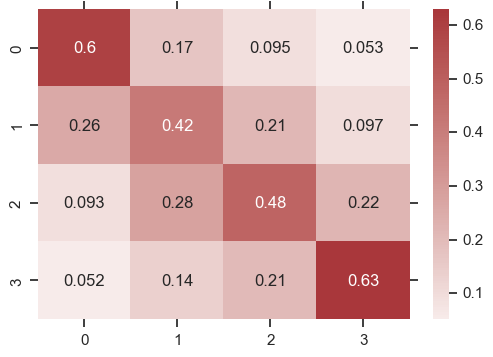

In [21]:
sns.heatmap(pos_diff/pos_diff.sum(axis=0), center=0, cmap="vlag", annot=True)

In [22]:
# score data preprocessing
score_preprocess = lambda x: int("".join(x.split(",")))
games["south_score"] = games["south_score"].apply(score_preprocess)
games["final_score"] = games["final_score"].apply(score_preprocess)

In [23]:
# Mean score
print("South main:", games["south_score"].mean(), games["south_position"].mean())
print("Final main:", games["final_score"].mean(), games["final_position"].mean())

South main: 24105.079365079364 2.5671957671957673
Final main: 23769.52380952381 2.596825396825397


/Users/jhsiao/anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


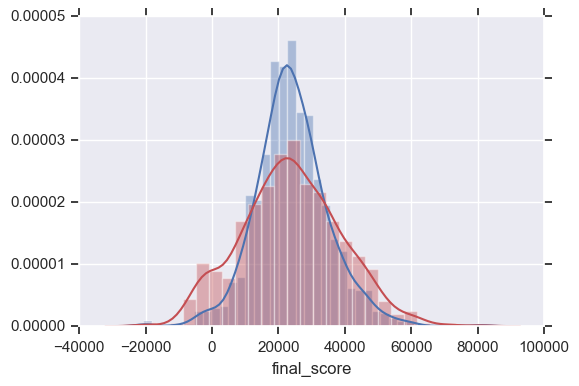

In [24]:
ax = sns.distplot(games["south_score"])
sns.distplot(games["final_score"], color="r", ax=ax)

## Defence

In [25]:
defence_hands = hands[hands["play_state"] == "DEFENCE"]

In [26]:
defence_hands.head(10)

,Unnamed: 0,score,score_diff,play_state,state_index,meld_times,reached,is_dealer,game_index,round_num,south_position,final_position
0,0,24000.0,-1000.0,DEFENCE,7,0,False,True,2019022301gm-0089-0000-1158e6c7&tw=0,0,4,2
9,9,23500.0,-1500.0,DEFENCE,10,0,False,False,2019022301gm-0089-0000-26a830fe&tw=2,0,4,4
10,10,22900.0,-600.0,DEFENCE,15,0,False,False,2019022301gm-0089-0000-26a830fe&tw=2,0,4,4
11,11,20900.0,-2000.0,DEFENCE,9,0,False,False,2019022301gm-0089-0000-26a830fe&tw=2,1,4,4
12,12,19900.0,-1000.0,DEFENCE,9,1,False,True,2019022301gm-0089-0000-26a830fe&tw=2,2,4,4
19,19,23000.0,0.0,DEFENCE,4,0,False,False,2019022302gm-0089-0000-abaec635&tw=3,2,3,3
31,31,13000.0,-12000.0,DEFENCE,7,1,False,False,2019022302gm-0089-0000-b8bc7f08&tw=3,0,4,4
33,33,13000.0,0.0,DEFENCE,11,0,False,False,2019022302gm-0089-0000-b8bc7f08&tw=3,1,4,4
34,34,700.0,-12300.0,DEFENCE,9,2,False,False,2019022302gm-0089-0000-b8bc7f08&tw=3,1,4,4
38,38,23000.0,0.0,DEFENCE,9,0,False,False,2019022303gm-0089-0000-9f12a69e&tw=1,2,3,3


In [27]:
print("Defence mean score diff:", defence_hands["score_diff"].mean())

Defence mean score diff: -1550.7080610021787


In [28]:
print("Lose big points when defence:", len(defence_hands[defence_hands["score_diff"] <= -6000])/len(defence_hands))

Lose big points when defence: 0.06345315904139434


/Users/jhsiao/anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-10000, 250)

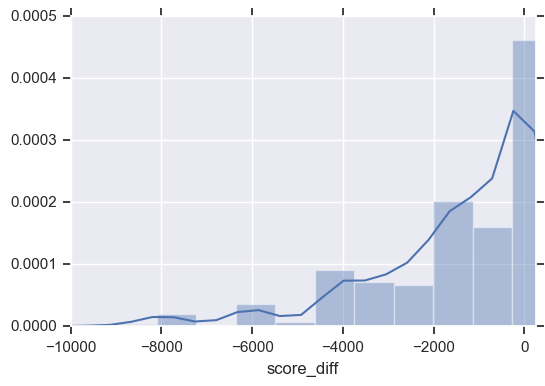

In [29]:
sns.distplot(defence_hands["score_diff"]).set_xlim(-10000, 250)

## Reasons why it got the 4th place

In [30]:
games_4th = games[games["final_position"] == 4]

In [31]:
hands_4th = hands[hands["final_position"] == 4]

### Play state with big score loss

In [32]:
hands_4th_bigloss = hands_4th[hands_4th["score_diff"] <= -6000]

In [33]:
hands_4th_bigloss.shape

(346, 12)

In [34]:
len(hands_4th_bigloss)/len(hands)

0.03158375171154724

In [35]:
hands_4th_bigloss.head(10)

,Unnamed: 0,score,score_diff,play_state,state_index,meld_times,reached,is_dealer,game_index,round_num,south_position,final_position
16,16,-3300.0,-18000.0,PUSHING,0,0,False,False,2019022301gm-0089-0000-26a830fe&tw=2,4,4,4
31,31,13000.0,-12000.0,DEFENCE,7,1,False,False,2019022302gm-0089-0000-b8bc7f08&tw=3,0,4,4
34,34,700.0,-12300.0,DEFENCE,9,2,False,False,2019022302gm-0089-0000-b8bc7f08&tw=3,1,4,4
70,70,15500.0,-7700.0,DEFENCE,3,0,False,False,2019022304gm-0089-0000-d8b61f13&tw=2,5,2,4
88,88,28000.0,-9000.0,PROACTIVE_BADSHAPE,5,0,True,True,2019022304gm-0089-0000-8c313e72&tw=1,1,4,4
89,89,20300.0,-7700.0,PREPARING,0,0,False,False,2019022304gm-0089-0000-8c313e72&tw=1,2,4,4
166,166,15000.0,-12000.0,DEFENCE,5,0,False,False,2019022308gm-0089-0000-9d875d82&tw=0,2,4,4
172,172,5900.0,-12000.0,PUSHING,0,3,False,False,2019022308gm-0089-0000-9d875d82&tw=0,6,4,4
290,290,15300.0,-6100.0,DEFENCE,9,0,False,True,2019022313gm-0089-0000-4caab2e8&tw=2,6,3,4
294,294,13000.0,-8000.0,PROACTIVE_BADSHAPE,12,0,False,False,2019022313gm-0089-0000-1e73e6b1&tw=0,2,4,4


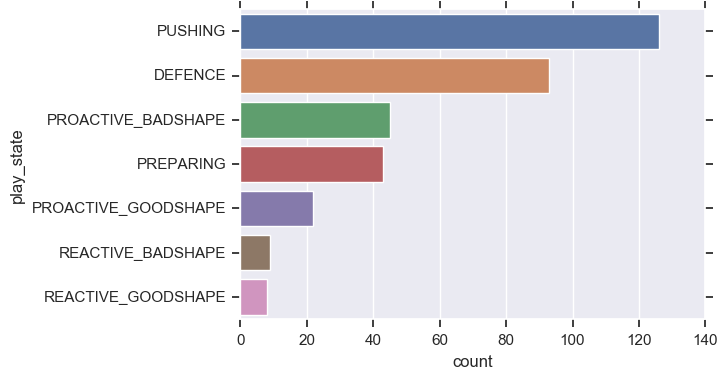

In [36]:
sns.countplot(y="play_state", data=hands_4th_bigloss)

### Category with south position

In [37]:
hands_S4 = hands[(hands["south_position"] == 4) & (hands["final_position"] == 4)]
hands_NS4 = hands[(hands["south_position"] != 4) & (hands["final_position"] == 4)]
print("South 4 final 4:", len(hands_S4)/len(hands))
print("South not 4 final 4:", len(hands_NS4)/len(hands))

South 4 final 4: 0.13464171611136466
South not 4 final 4: 0.12578731172980373


### South 4 and final 4

In first 3 rounds, check which state cause big score loss.

In [38]:
hands_S4[(hands_S4["score_diff"] <= -6000) & (hands_S4["round_num"] <= 2)].head(10)

,Unnamed: 0,score,score_diff,play_state,state_index,meld_times,reached,is_dealer,game_index,round_num,south_position,final_position
31,31,13000.0,-12000.0,DEFENCE,7,1,False,False,2019022302gm-0089-0000-b8bc7f08&tw=3,0,4,4
34,34,700.0,-12300.0,DEFENCE,9,2,False,False,2019022302gm-0089-0000-b8bc7f08&tw=3,1,4,4
88,88,28000.0,-9000.0,PROACTIVE_BADSHAPE,5,0,True,True,2019022304gm-0089-0000-8c313e72&tw=1,1,4,4
89,89,20300.0,-7700.0,PREPARING,0,0,False,False,2019022304gm-0089-0000-8c313e72&tw=1,2,4,4
166,166,15000.0,-12000.0,DEFENCE,5,0,False,False,2019022308gm-0089-0000-9d875d82&tw=0,2,4,4
294,294,13000.0,-8000.0,PROACTIVE_BADSHAPE,12,0,False,False,2019022313gm-0089-0000-1e73e6b1&tw=0,2,4,4
408,408,13000.0,-12000.0,DEFENCE,10,0,False,False,2019022319gm-0089-0000-94bab2b6&tw=3,0,4,4
491,491,17000.0,-8000.0,PREPARING,0,0,False,True,2019022323gm-0089-0000-ad42a2d2&tw=2,2,4,4
629,629,13000.0,-12000.0,PREPARING,0,1,False,False,2019022405gm-0089-0000-9e9d966d&tw=1,0,4,4
630,630,6900.0,-6100.0,PREPARING,0,1,False,False,2019022405gm-0089-0000-9e9d966d&tw=1,0,4,4


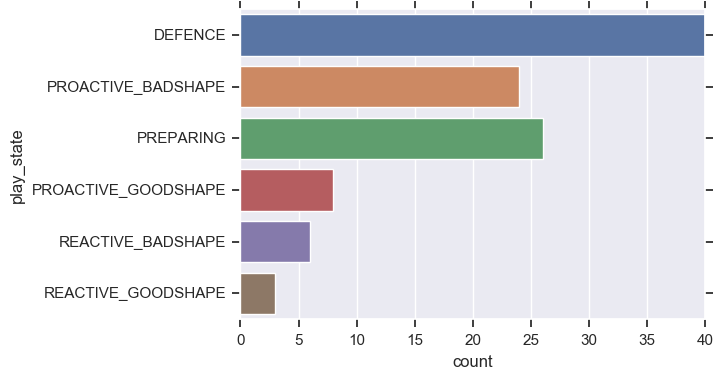

In [39]:
sns.countplot(y="play_state", data=hands_S4[(hands_S4["score_diff"] <= -6000) & (hands_S4["round_num"] <= 2)])

It seems like plenty of big score loss are caused by defence. Time to do some error analysis.

In [40]:
big_loss_early_hands = hands_S4[(hands_S4["score_diff"] <= -6000) & (hands_S4["round_num"] <= 2)]

In [41]:
big_loss_early_hands[big_loss_early_hands["play_state"] == "DEFENCE"]

,Unnamed: 0,score,score_diff,play_state,state_index,meld_times,reached,is_dealer,game_index,round_num,south_position,final_position
31,31,13000.0,-12000.0,DEFENCE,7,1,False,False,2019022302gm-0089-0000-b8bc7f08&tw=3,0,4,4
34,34,700.0,-12300.0,DEFENCE,9,2,False,False,2019022302gm-0089-0000-b8bc7f08&tw=3,1,4,4
166,166,15000.0,-12000.0,DEFENCE,5,0,False,False,2019022308gm-0089-0000-9d875d82&tw=0,2,4,4
408,408,13000.0,-12000.0,DEFENCE,10,0,False,False,2019022319gm-0089-0000-94bab2b6&tw=3,0,4,4
633,633,400.0,-6000.0,DEFENCE,10,0,False,False,2019022405gm-0089-0000-9e9d966d&tw=1,2,4,4
710,710,19000.0,-6000.0,DEFENCE,6,0,False,False,2019022409gm-0089-0000-f2f2e2e9&tw=0,2,4,4
925,925,12600.0,-6000.0,DEFENCE,4,0,False,False,2019022418gm-0089-0000-461944e0&tw=3,2,4,4
1142,1142,17300.0,-7700.0,DEFENCE,6,0,False,False,2019022503gm-0089-0000-174fd2e5&tw=0,2,4,4
1274,1274,20900.0,-6000.0,DEFENCE,4,0,False,True,2019022508gm-0089-0000-0f75055c&tw=2,2,4,4
1297,1297,16000.0,-9000.0,DEFENCE,9,0,True,False,2019022510gm-0089-0000-839e93a0&tw=3,0,4,4


In [42]:
S4_defence_game_indexes = big_loss_early_hands[big_loss_early_hands["play_state"] == "DEFENCE"]["game_index"].unique()

In [43]:
for game_index in S4_defence_game_indexes:
    print("http://tenhou.net/3/?log="+game_index+"\n")

http://tenhou.net/3/?log=2019022302gm-0089-0000-b8bc7f08&tw=3

http://tenhou.net/3/?log=2019022308gm-0089-0000-9d875d82&tw=0

http://tenhou.net/3/?log=2019022319gm-0089-0000-94bab2b6&tw=3

http://tenhou.net/3/?log=2019022405gm-0089-0000-9e9d966d&tw=1

http://tenhou.net/3/?log=2019022409gm-0089-0000-f2f2e2e9&tw=0

http://tenhou.net/3/?log=2019022418gm-0089-0000-461944e0&tw=3

http://tenhou.net/3/?log=2019022503gm-0089-0000-174fd2e5&tw=0

http://tenhou.net/3/?log=2019022508gm-0089-0000-0f75055c&tw=2

http://tenhou.net/3/?log=2019022510gm-0089-0000-839e93a0&tw=3

http://tenhou.net/3/?log=2019022511gm-0089-0000-40979aa3&tw=3

http://tenhou.net/3/?log=2019022301gm-0089-0000-33b8ad66&tw=0

http://tenhou.net/3/?log=2019022317gm-0089-0000-0a755c72&tw=0

http://tenhou.net/3/?log=2019022402gm-0089-0000-f6680469&tw=3

http://tenhou.net/3/?log=2019022413gm-0089-0000-8650bf3e&tw=1

http://tenhou.net/3/?log=2019022500gm-0089-0000-16c4e36c&tw=1

http://tenhou.net/3/?log=2019022507gm-0089-0000-2607de7

### South not 4 and final 4

See why there are big score losses in south rounds.

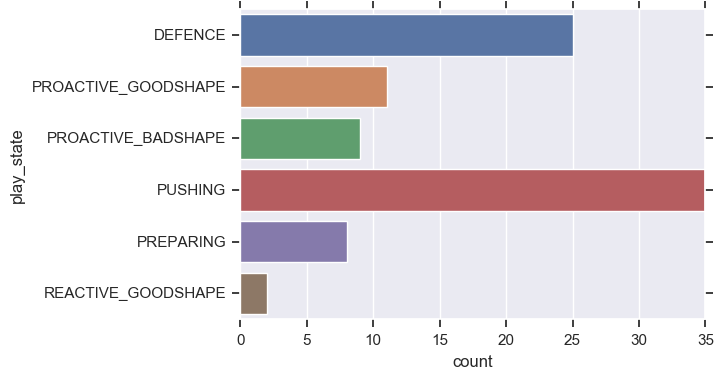

In [44]:
sns.countplot(y="play_state", data=hands_NS4[(hands_NS4["round_num"] >= 4) & (hands_NS4["score_diff"] <= -6000)])

/Users/jhsiao/anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


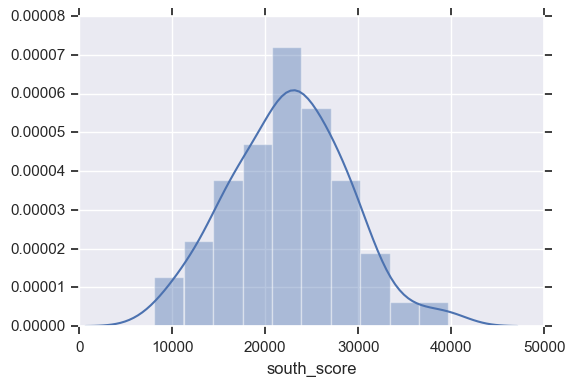

In [45]:
sns.distplot(games[(games["south_position"] != 4) & (games["final_position"] == 4)]["south_score"])

In [46]:
for game_index in hands_NS4["game_index"].unique():
    print("http://tenhou.net/3/?log="+game_index+"\n")

http://tenhou.net/3/?log=2019022304gm-0089-0000-d8b61f13&tw=2

http://tenhou.net/3/?log=2019022313gm-0089-0000-4caab2e8&tw=2

http://tenhou.net/3/?log=2019022314gm-0089-0000-1df7963c&tw=0

http://tenhou.net/3/?log=2019022405gm-0089-0000-3e0dbe5e&tw=3

http://tenhou.net/3/?log=2019022412gm-0089-0000-2ca35ea9&tw=1

http://tenhou.net/3/?log=2019022505gm-0089-0000-5936d181&tw=3

http://tenhou.net/3/?log=2019022510gm-0089-0000-3d42a55e&tw=2

http://tenhou.net/3/?log=2019022515gm-0089-0000-b0448098&tw=0

http://tenhou.net/3/?log=2019022304gm-0089-0000-792190cd&tw=0

http://tenhou.net/3/?log=2019022310gm-0089-0000-58c93059&tw=1

http://tenhou.net/3/?log=2019022311gm-0089-0000-6e862617&tw=1

http://tenhou.net/3/?log=2019022312gm-0089-0000-558dfc39&tw=3

http://tenhou.net/3/?log=2019022313gm-0089-0000-50d0ce53&tw=3

http://tenhou.net/3/?log=2019022321gm-0089-0000-b79962bb&tw=0

http://tenhou.net/3/?log=2019022322gm-0089-0000-32e9d599&tw=3

http://tenhou.net/3/?log=2019022400gm-0089-0000-e39d931

### South 1 and final not 1

In [47]:
hands_S1 = hands[(hands["south_position"] == 1) & (hands["final_position"] != 1)]

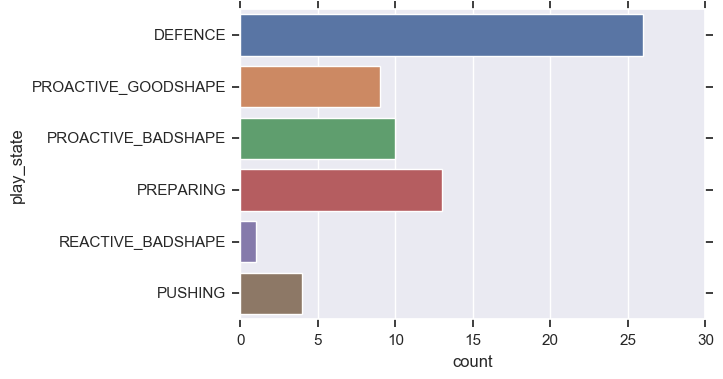

In [48]:
# more than -3900
sns.countplot(y="play_state", data=hands_S1[(hands_S1["round_num"] >= 4) & (hands_S1["score_diff"] <= -3900)])

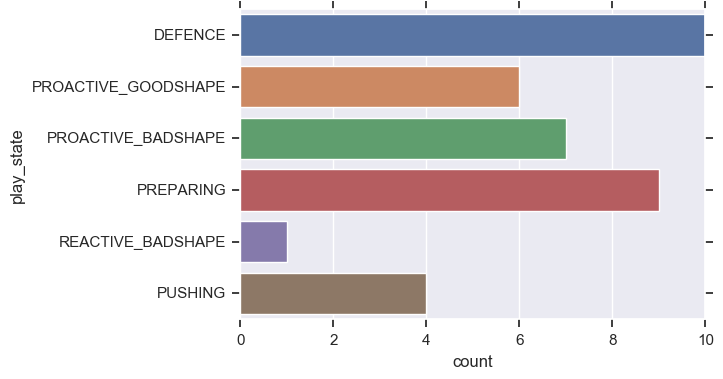

In [49]:
# more than -6000
sns.countplot(y="play_state", data=hands_S1[(hands_S1["round_num"] >= 4) & (hands_S1["score_diff"] <= -6000)])

/Users/jhsiao/anaconda/envs/py3/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


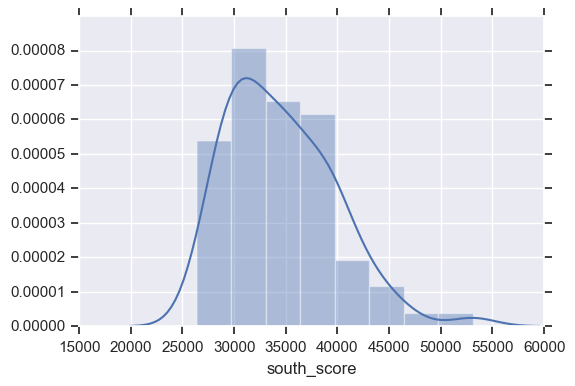

In [50]:
sns.distplot(games[(games["south_position"] == 1) & (games["final_position"] != 1)]["south_score"])

In [51]:
for game_index in hands_S1[(hands_S1["round_num"] >= 4) & (hands_S1["score_diff"] <= -6000)]["game_index"].unique():
    print("http://tenhou.net/3/?log="+game_index+"\n")

http://tenhou.net/3/?log=2019022314gm-0089-0000-1df7963c&tw=0

http://tenhou.net/3/?log=2019022319gm-0089-0000-09e86ced&tw=2

http://tenhou.net/3/?log=2019022405gm-0089-0000-3e0dbe5e&tw=3

http://tenhou.net/3/?log=2019022420gm-0089-0000-78054a6e&tw=0

http://tenhou.net/3/?log=2019022423gm-0089-0000-30a3f347&tw=1

http://tenhou.net/3/?log=2019022504gm-0089-0000-2fb271a2&tw=2

http://tenhou.net/3/?log=2019022500gm-0089-0000-1949a42d&tw=3

http://tenhou.net/3/?log=2019022503gm-0089-0000-14a4a697&tw=1

http://tenhou.net/3/?log=2019022508gm-0089-0000-4cd5f9f3&tw=2

http://tenhou.net/3/?log=2019022512gm-0089-0000-b55db7e7&tw=1

http://tenhou.net/3/?log=2019022302gm-0089-0000-e1de8d52&tw=0

http://tenhou.net/3/?log=2019022400gm-0089-0000-9c8e9bb4&tw=3

http://tenhou.net/3/?log=2019022405gm-0089-0000-58c1ac28&tw=2

http://tenhou.net/3/?log=2019022500gm-0089-0000-ea78f4fa&tw=1

http://tenhou.net/3/?log=2019022502gm-0089-0000-f583638a&tw=0

http://tenhou.net/3/?log=2019022503gm-0089-0000-eba09ae

## Error Analysis

In [52]:
games.head()

,Unnamed: 0,game_index,south_score,final_score,south_position,final_position
0,0,2019022301gm-0089-0000-1158e6c7&tw=0,19800,30300,4,2
1,1,2019022301gm-0089-0000-26a830fe&tw=2,14700,-3300,4,4
2,2,2019022302gm-0089-0000-abaec635&tw=3,18000,11300,3,3
3,3,2019022302gm-0089-0000-b8bc7f08&tw=3,-2800,-2800,4,4
4,4,2019022303gm-0089-0000-9f12a69e&tw=1,31000,25500,3,3


In [53]:
game_indexes_4 = games[games["final_position"]==4]["game_index"]

In [54]:
for game_index in game_indexes_4:
    print("http://tenhou.net/3/?log="+game_index+"\n")

http://tenhou.net/3/?log=2019022301gm-0089-0000-26a830fe&tw=2

http://tenhou.net/3/?log=2019022302gm-0089-0000-b8bc7f08&tw=3

http://tenhou.net/3/?log=2019022304gm-0089-0000-d8b61f13&tw=2

http://tenhou.net/3/?log=2019022304gm-0089-0000-8c313e72&tw=1

http://tenhou.net/3/?log=2019022307gm-0089-0000-19ac1428&tw=2

http://tenhou.net/3/?log=2019022308gm-0089-0000-9d875d82&tw=0

http://tenhou.net/3/?log=2019022313gm-0089-0000-4caab2e8&tw=2

http://tenhou.net/3/?log=2019022313gm-0089-0000-1e73e6b1&tw=0

http://tenhou.net/3/?log=2019022314gm-0089-0000-1df7963c&tw=0

http://tenhou.net/3/?log=2019022319gm-0089-0000-94bab2b6&tw=3

http://tenhou.net/3/?log=2019022320gm-0089-0000-31f290cc&tw=3

http://tenhou.net/3/?log=2019022321gm-0089-0000-04f44b7e&tw=3

http://tenhou.net/3/?log=2019022323gm-0089-0000-ad42a2d2&tw=2

http://tenhou.net/3/?log=2019022404gm-0089-0000-e4060286&tw=1

http://tenhou.net/3/?log=2019022405gm-0089-0000-9e9d966d&tw=1

http://tenhou.net/3/?log=2019022405gm-0089-0000-3e0dbe5